# Scanpy Processing of UCSC Organoid Data

Basically trying to recapitulate the analysis in the organoid paper in Python. Pulls heavily from https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html


## Imports

This notebook has the following dependencies:
* scanpy : a library for interacting with and analyzing single-cell RNAseq data. Contains many useful functions for pre-processing, dimensionality reduction, and clustering. 
* anndata : a library containing classes to hold single-cell RNAseq data. 
* read.py : personally written function to read in scRNAseq as a numpy array in a line-by-line fashion. necessary because for some reason the scanpy library function seems to require 2x the amount of memory necessary for their read function, which seems to me like they're reading the whole file into memory and then doing the conversion. 

In [1]:
from read import *
import scanpy
import anndata
import numpy as np
scanpy.settings.set_figure_params(dpi = 300, facecolor = 'white')

/home/sban/miniconda3/envs/organoid/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


## Data and data exploration

We use the custom read function to read in the scRNAseq data for the UCSC organoid dataset. The variable 'ad' is an AnnData object; all subsequent processing in scanpy operates on AnnData objects. 

In [2]:
ad = read_organoid_ucsc_scanpy() 
#this loads approx. 7gb into memory, and takes about 3 min

Process Process-2:
Traceback (most recent call last):
  File "/home/sban/miniconda3/envs/organoid/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/sban/miniconda3/envs/organoid/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sban/Documents/organoid_analysis/read.py", line 26, in do_work
    out_list.append([line_no, line_list[0], np.array(line_list[1:]).astype(dtype)])
ValueError: could not convert string to float: 'WTC10SWeek10_TTCTTAGGTGTGCGTC'


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000


Transforming to str index.


We can then see what the data type looks like. Basically it seems to be a light wrapper over a numpy array that brings along some annotations over both cells and genes containing information like the sample, protocol used to generate the cell, as well as the class, state, type, and subtypes as found in the paper. Note that the shape is n_obs x n_vars (obs ~ cells, vars ~ genes), and the annotations for each contain key-indexed annotations for each cell or gene.  

In [4]:
ad

AnnData object with n_obs × n_vars = 235121 × 16774 
    obs: 'V1', 'Cluster', 'Sample', 'Line', 'Protocol', 'Age', 'iPSCorhESC', 'Class', 'State', 'Type', 'Subtype'
    var: 'gene_name'

In [23]:
ad.obs.head()

,V1,Cluster,Sample,Line,Protocol,Age,iPSCorhESC,Class,State,Type,Subtype
0,H1SWeek3_AAACCTGAGACAAAGG,29,H1SWeek3,H1,Less Directed,3,hESC,Nonneuronal,Dividing,RadialGlia,panRG
1,H1SWeek3_AAACCTGAGCACACAG,5,H1SWeek3,H1,Less Directed,3,hESC,Nonneuronal,Dividing,RadialGlia,panRG
2,H1SWeek3_AAACCTGAGGATGGAA,35,H1SWeek3,H1,Less Directed,3,hESC,Nonneuronal,Dividing,RadialGlia,panRG
3,H1SWeek3_AAACCTGCAATTGCTG,36,H1SWeek3,H1,Less Directed,3,hESC,Nonneuronal,Nondividing,RadialGlia,hindbrainRG
4,H1SWeek3_AAACCTGCAGCGTAAG,5,H1SWeek3,H1,Less Directed,3,hESC,Nonneuronal,Dividing,RadialGlia,panRG


We can create some views of the data based on highest fraction of counts in each single cell

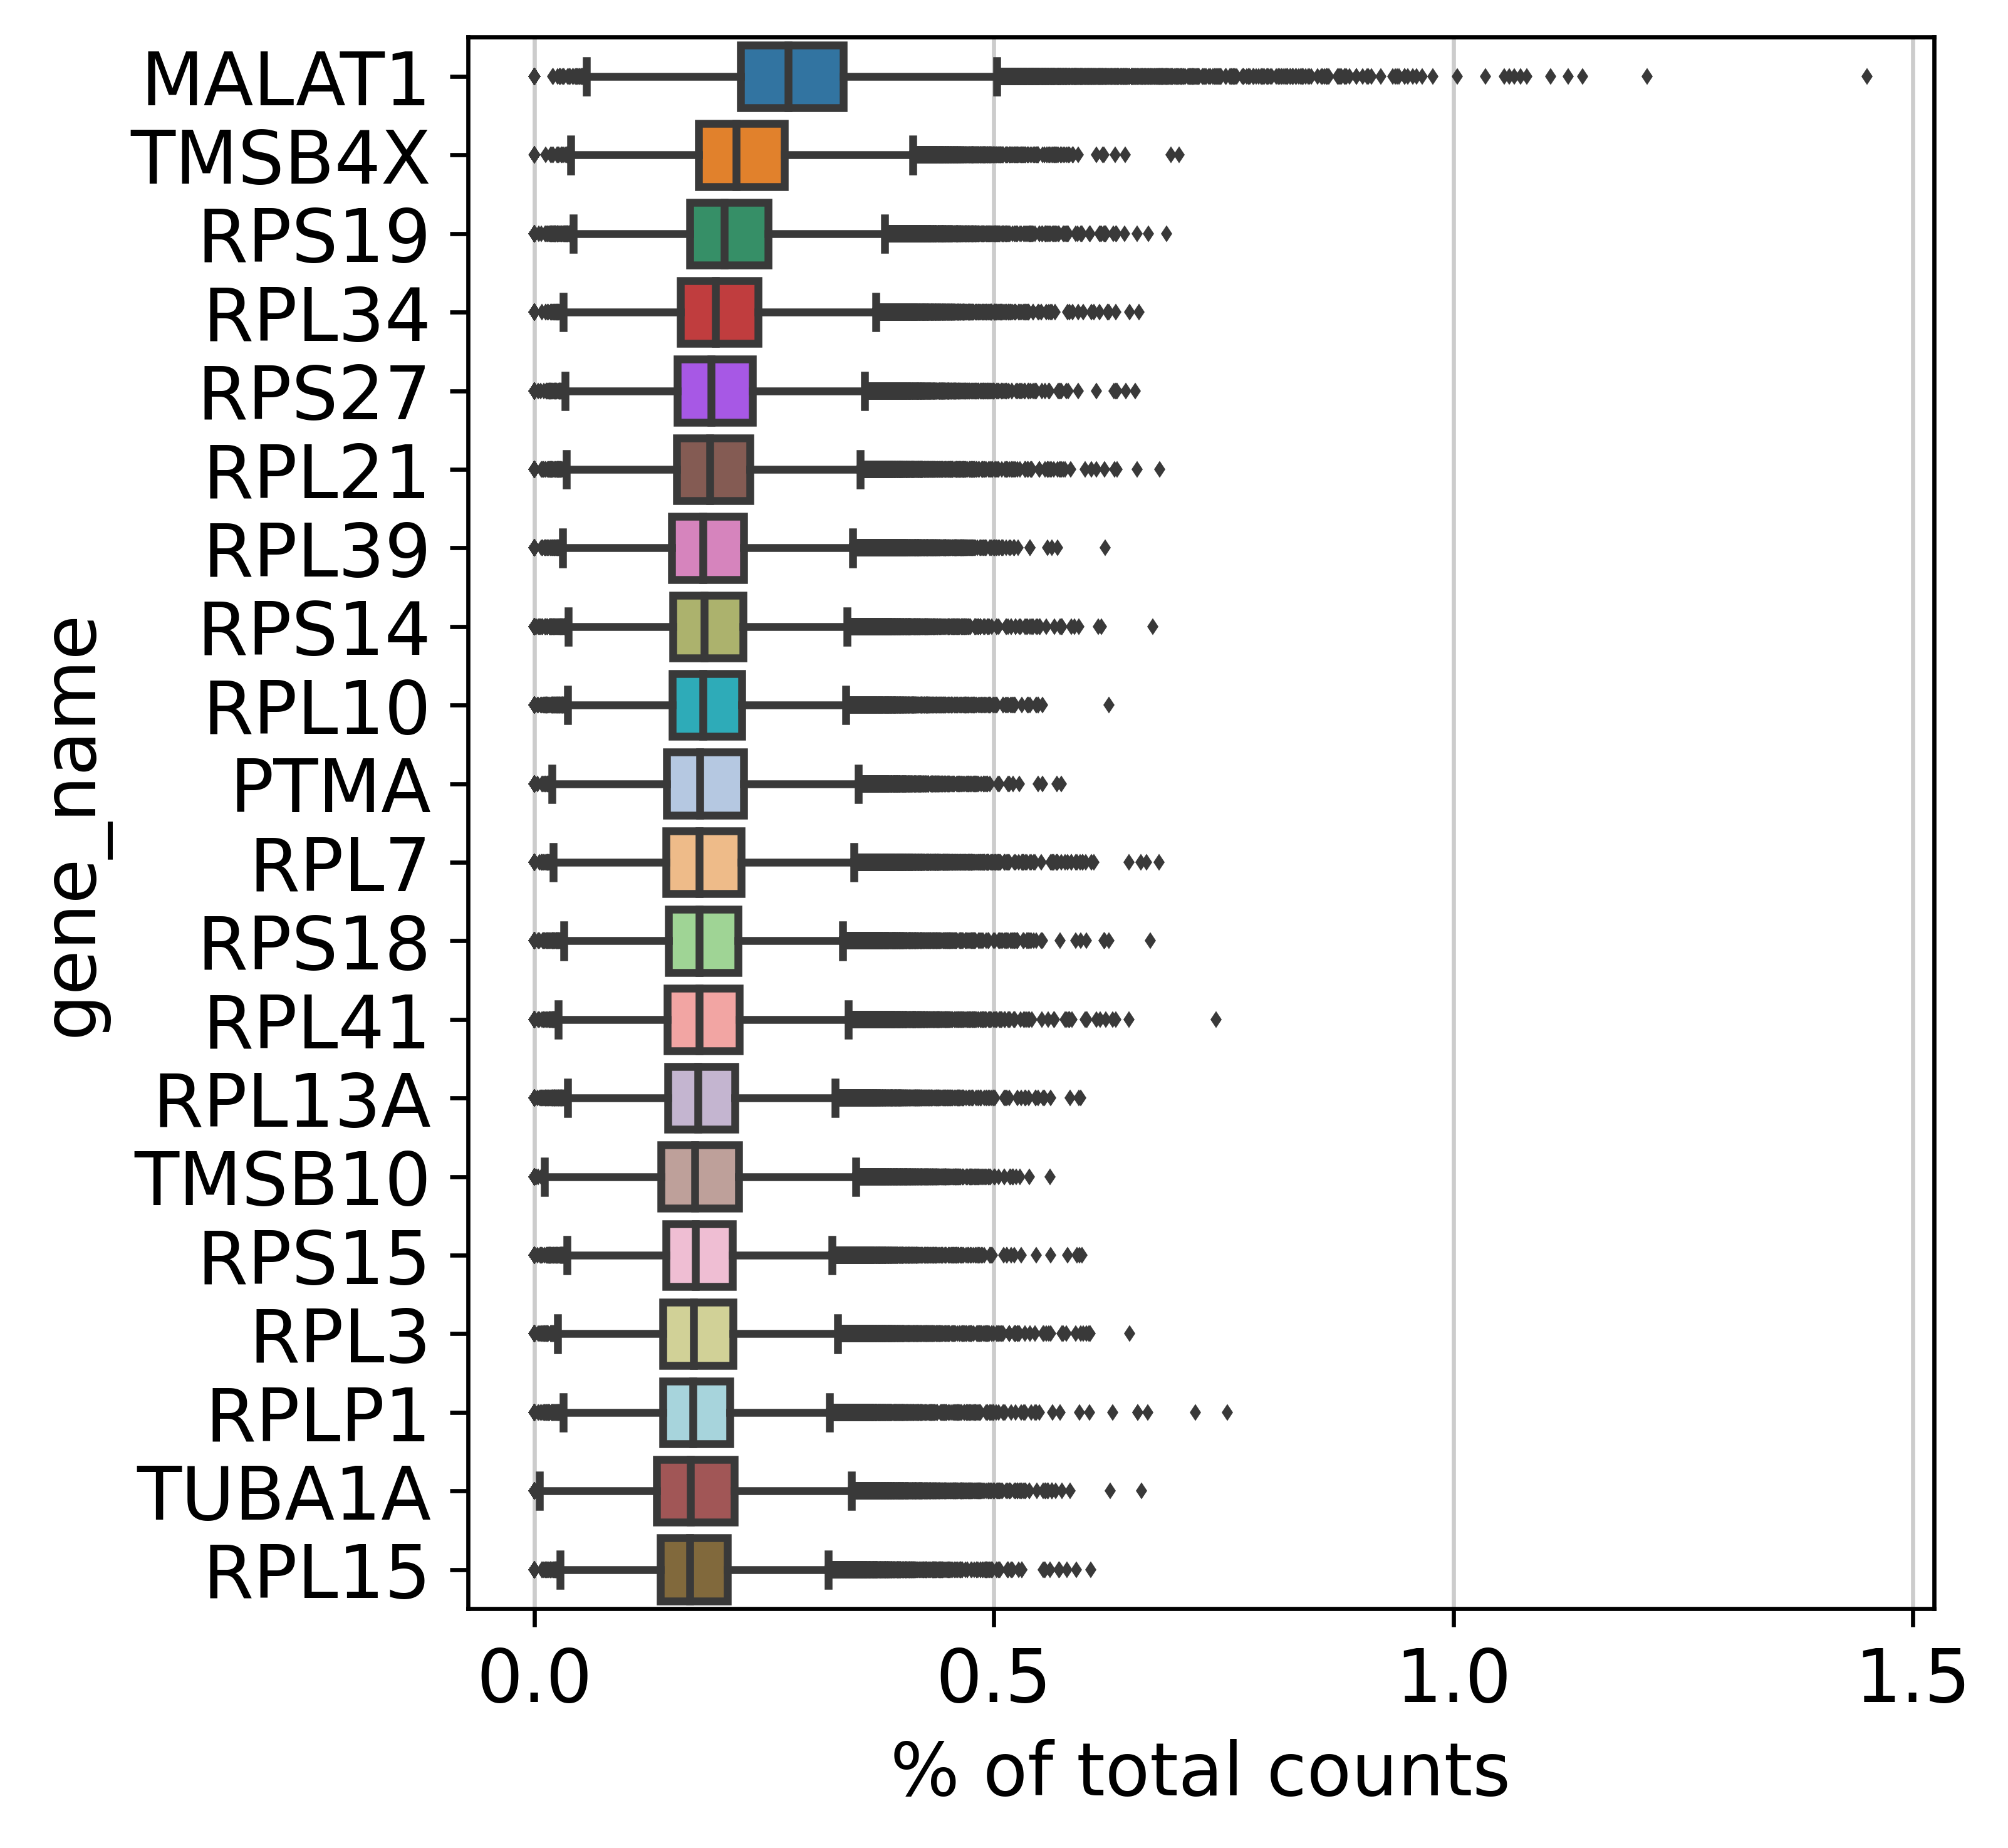

In [25]:
scanpy.pl.highest_expr_genes(ad, n_top=20, ) 
#this took approx 2 min with maximal memory usage of ~15gb

And some plots relating to the percent of counts relating to mitochondrial genes

In [3]:
# next 2 lines are to calculate mitochondrial counts 
ad.var['mt'] = ad.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
scanpy.pp.calculate_qc_metrics(ad, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# max mem : 11gb
# time : about 1 min

/home/sban/miniconda3/envs/organoid/lib/python3.6/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


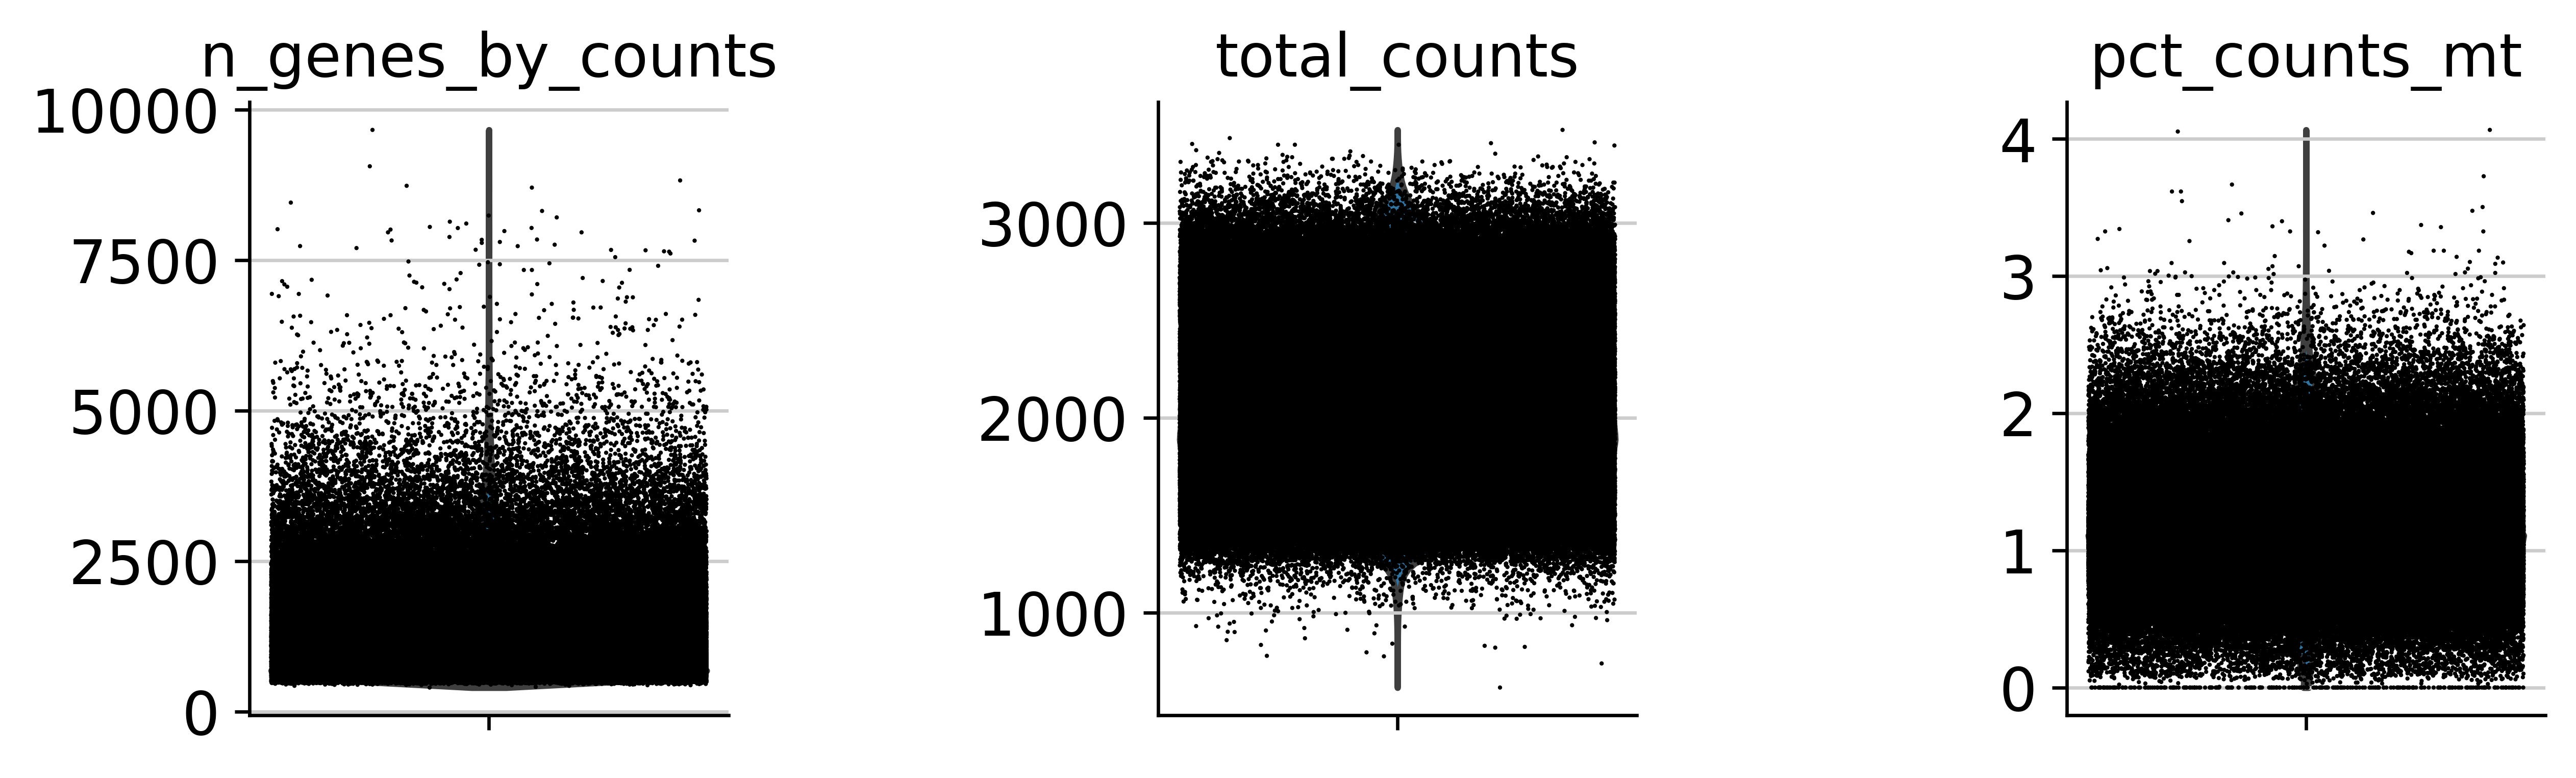

In [24]:
scanpy.pl.violin(ad, ['n_genes_by_counts', 'total_counts','pct_counts_mt'], 
             jitter=0.4, multi_panel=True)

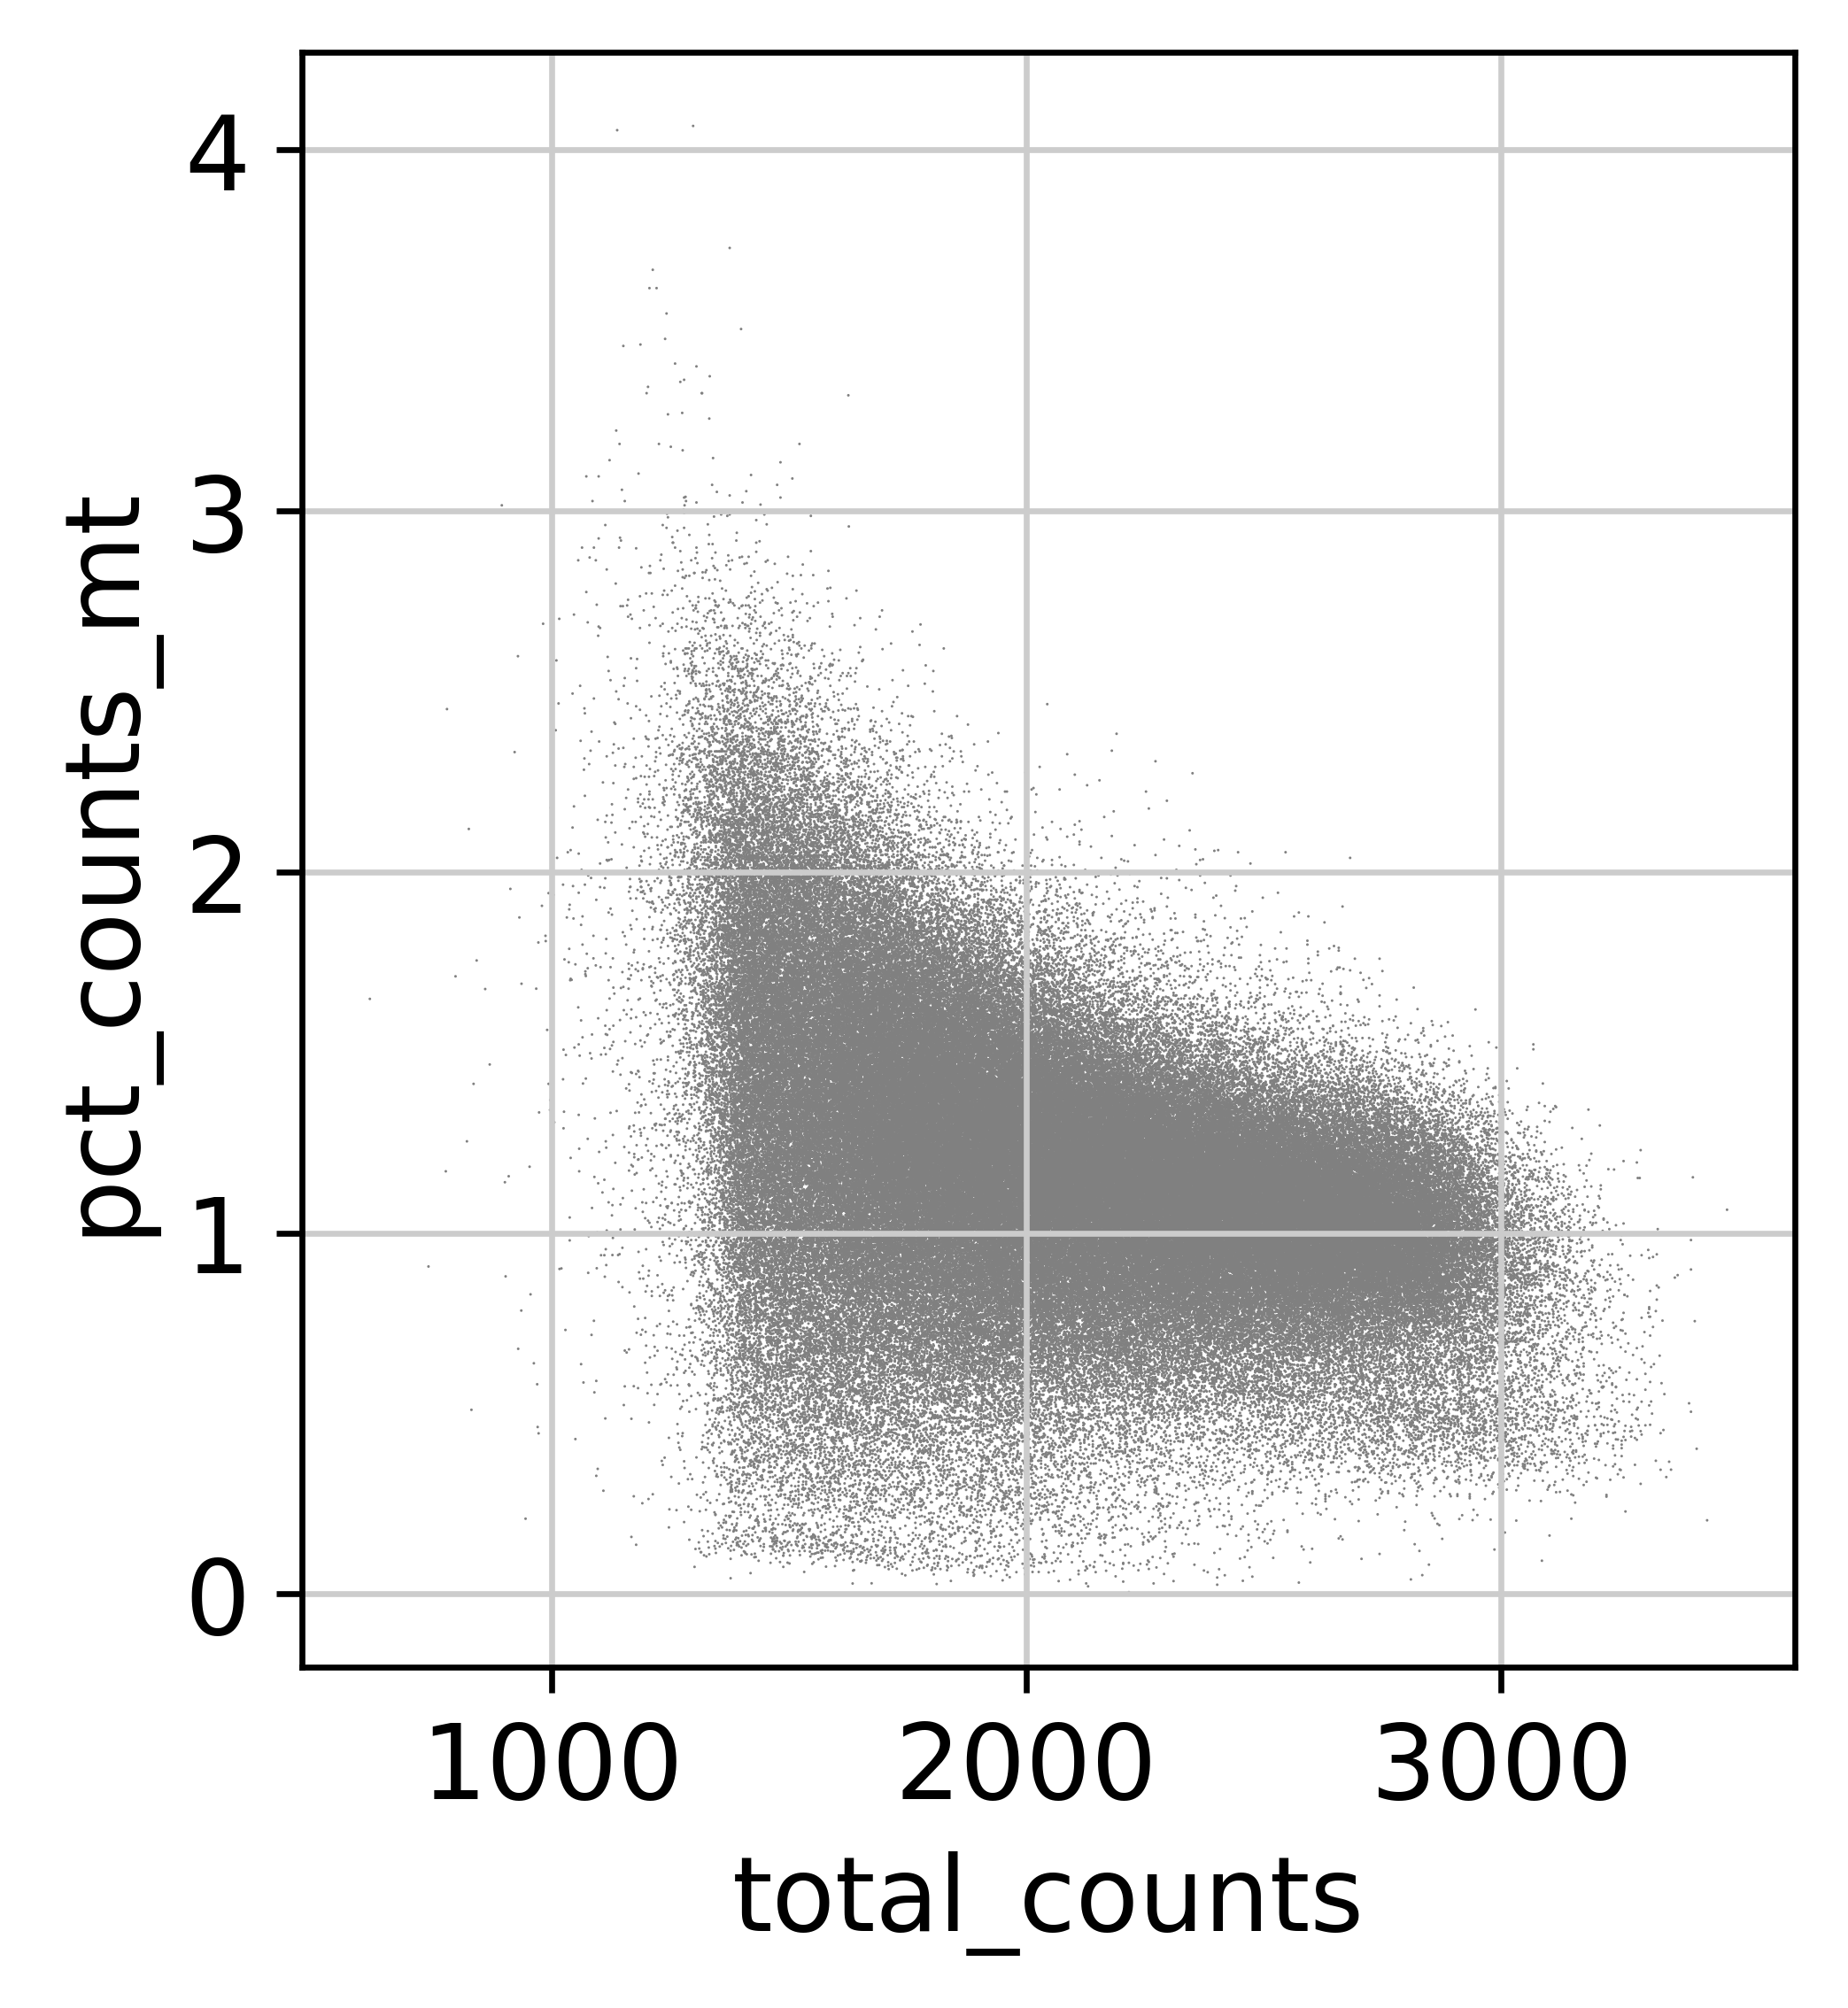

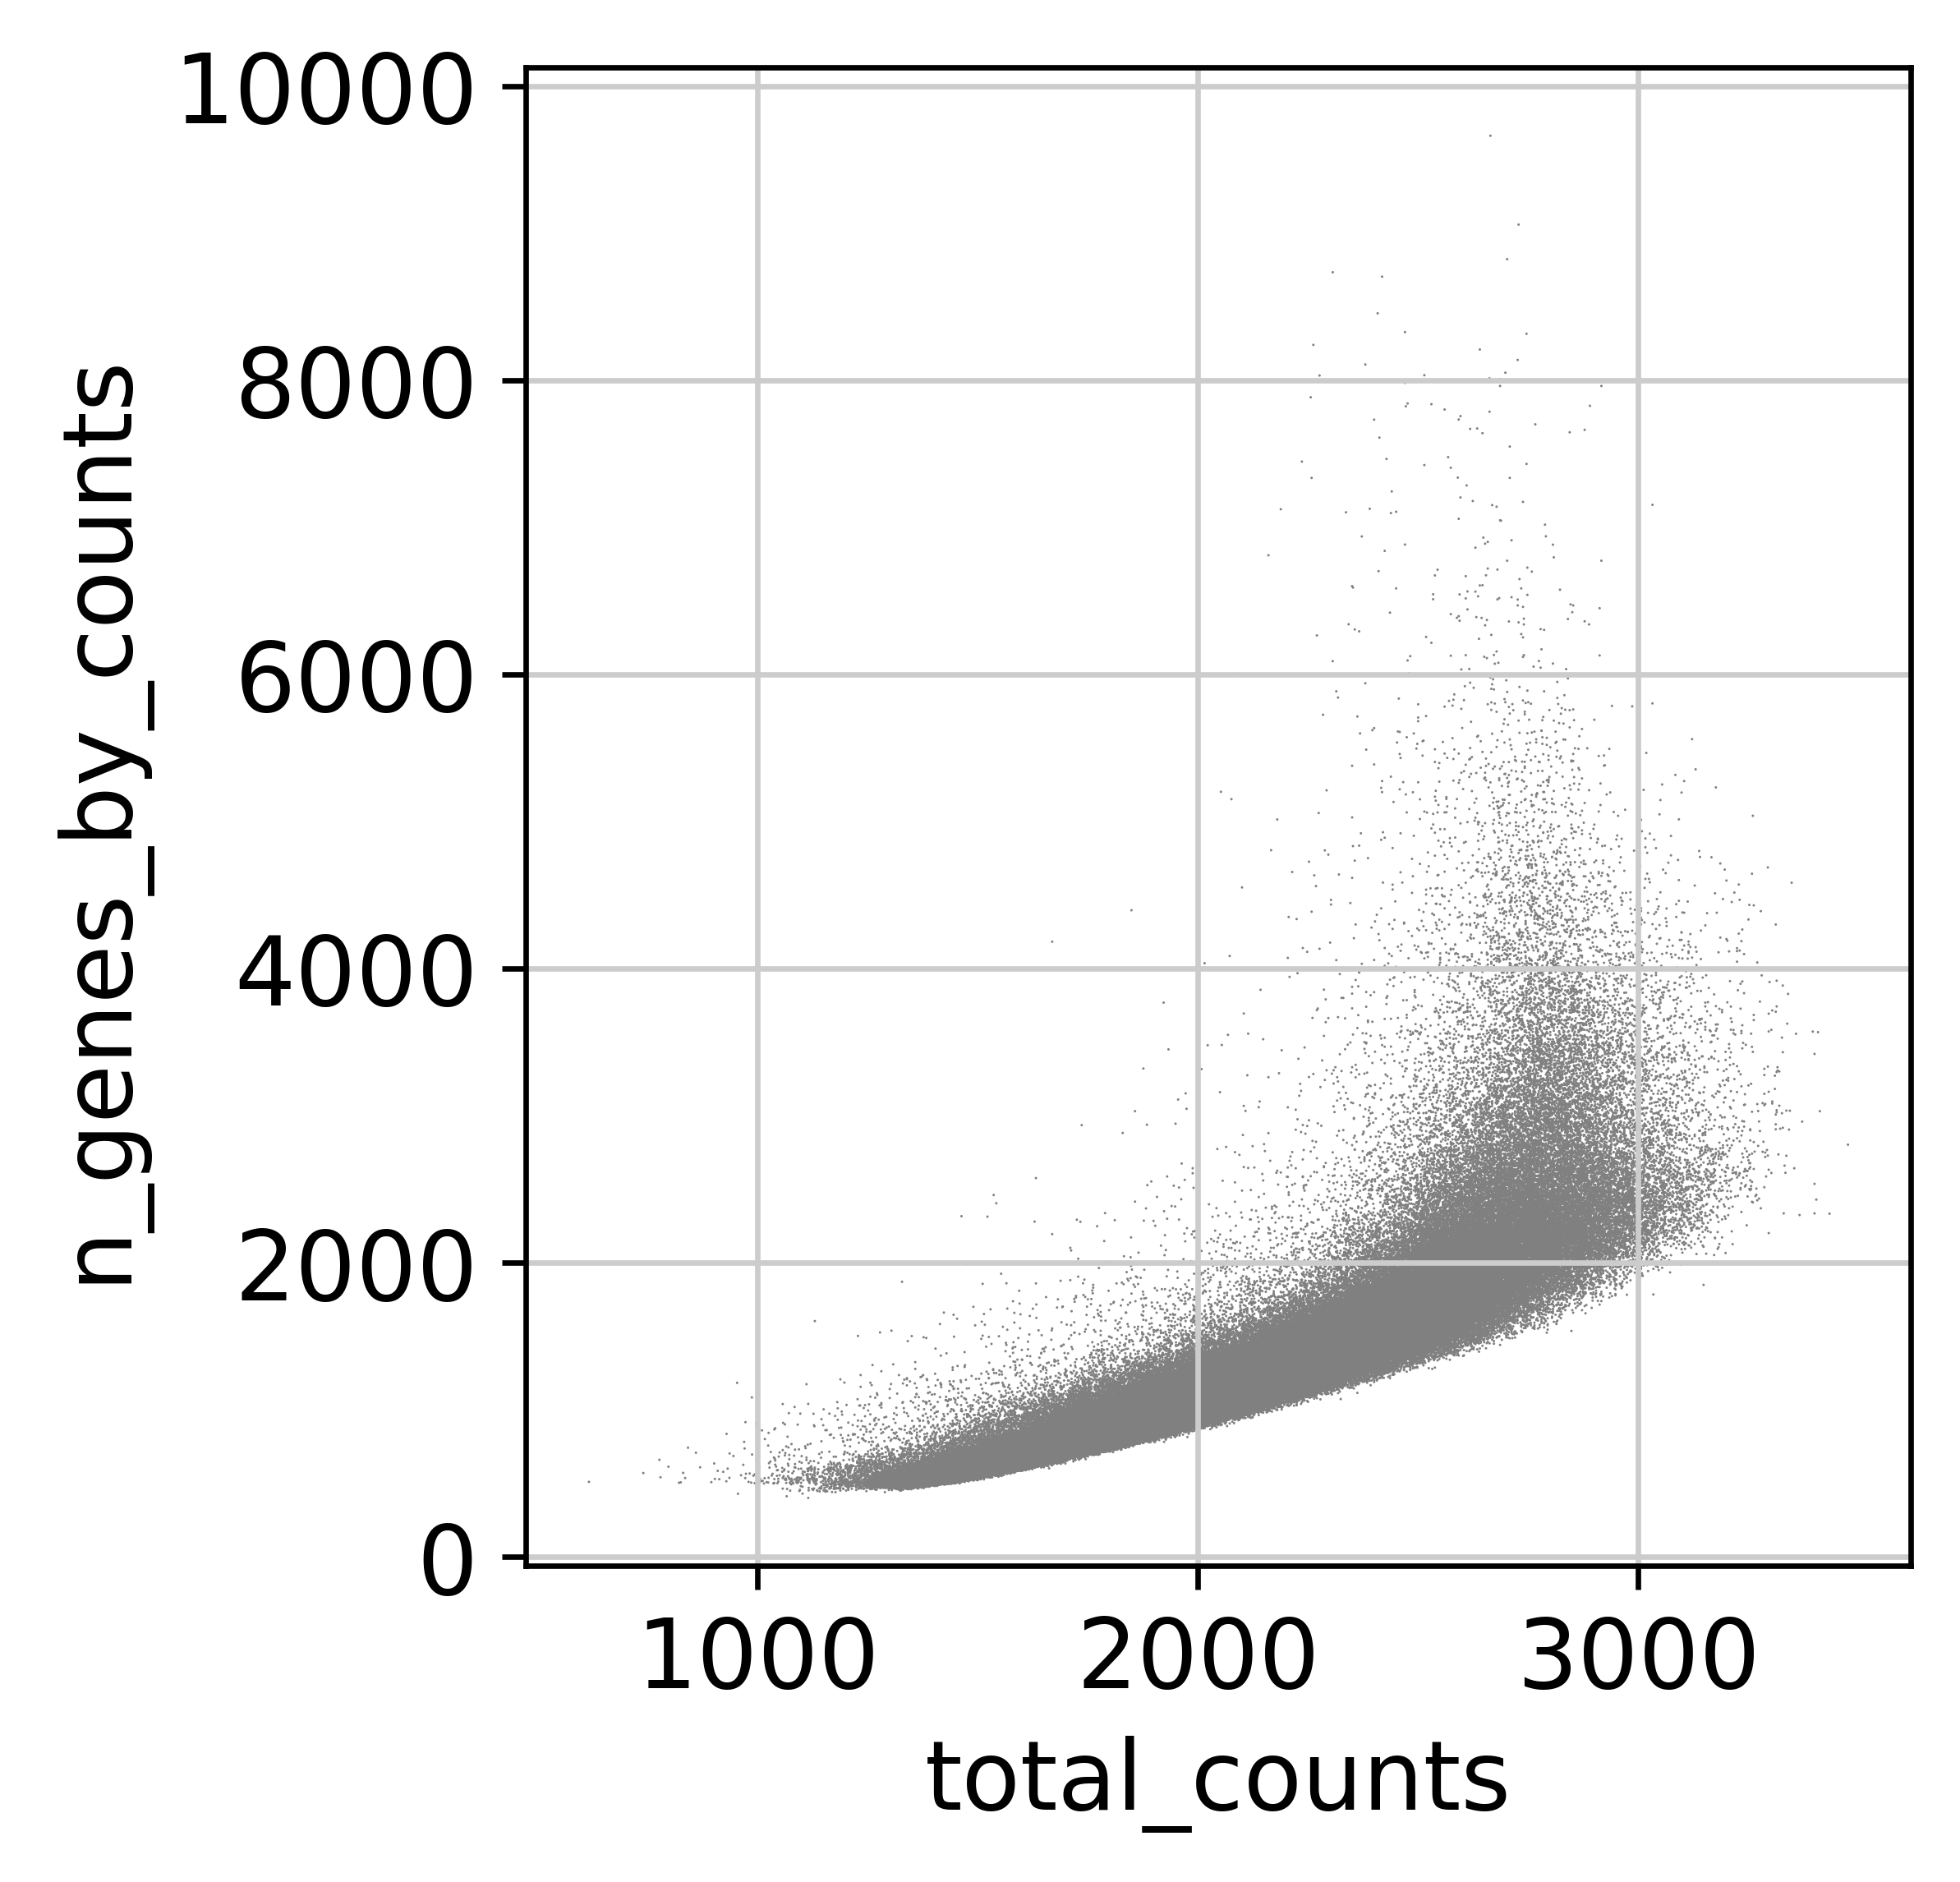

In [27]:
scanpy.pl.scatter(ad, x='total_counts', y='pct_counts_mt')
scanpy.pl.scatter(ad, x='total_counts', y='n_genes_by_counts')

## Preprocessing

Now, we begin to follow the steps outlined in the paper. Since we are already reading in a normalized expression matrix, we only need to perform the following steps:

1. Discard cells with fewer than 500 genes per cell
2. Discard cells with more than 10% of reads aligning to mitochondrial genes (indicative of poor quality cells)
3. Log_2 transform the data

In [4]:
# filter cells with fewer than 500 genes expressed per cell
scanpy.pp.filter_cells(ad, min_genes=500, inplace = True) 
# max mem : 20gb
# time : 1m15s

In [5]:
# filter cells with more than 10% of reads aligning to mitochondrial genes
ad = ad[ad.obs.pct_counts_mt < 10, :]
# this was really fast, kinda scarily fast, like on order of ms

In [6]:
# log2 transform - note that returns log_2(1+X) to handle 0 values

ad.X = np.log2(ad.X + 1)
ad.X = ad.X.astype(np.float16)
# scanpy.pp.log1p(ad, base = 2, copy = False, chunked = True, chunk_size = 10000)
# ^ this function call also unoptimized, replace with numpy version of the function
# max mem : 21gb (3x)
# time : about 45s

## Processing

Now we can start processing and finding variable genes

In [24]:
# performs default seurat variable genes
results = scanpy.pp.highly_variable_genes(ad, min_mean = 0.0125, max_mean = 3, min_disp = 0.5, inplace = False)
# max mem : 22gb
# time : 

In [25]:
np.sum(results['highly_variable'])

2525

In [26]:
results.columns

Index(['means', 'dispersions', 'mean_bin', 'dispersions_norm',
       'highly_variable'],
      dtype='object')

In [1]:
ad.var.join(results)['mean_bin']

NameError: name 'ad' is not defined

In [ ]:
'''
for column in results.columns:
    ad.var[column] = results[column].values
'''
# this function call copies the entire object somehow

Trying to set attribute `.var` of view, copying.
